In [ ]:
! pip install chainer
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from subprocess import check_output
import time
import math
import random
import copy
import torch
from sklearn.utils import shuffle
import chainer
import chainer.functions as F
import chainer.links as L
from plotly import tools
from plotly.graph_objs import *
from plotly.offline import init_notebook_mode, iplot, iplot_mpl
init_notebook_mode(connected=True)

Dataset

In [ ]:
df = pd.read_csv('/content/PL11_data_all_En.csv')
df.head()

,Cycles,Capacity,PerEn3
0,6,1.4393,1.8572
1,11,1.4360,1.8107
2,16,1.4335,1.7562
3,21,1.4314,1.7692
4,26,1.4282,1.8305


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133 entries, 0 to 132
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Cycles    133 non-null    int64  
 1   Capacity  133 non-null    float64
 2   PerEn3    133 non-null    float64
dtypes: float64(2), int64(1)
memory usage: 3.2 KB


In [ ]:
df.drop({'Cycles'},axis=1,inplace=True)
#data = shuffle(df)
train = df[:119]
test = df[119:]

Environmet

In [ ]:
class Environment1:
    
    def __init__(self, data, history_t=10):
        self.data = data
        self.history_t = history_t
        self.reset()
        
    def reset(self):
        self.t = 0
        self.done = False
        self.profits = 0
        self.positions = []
        self.position_value = 0
        self.history = [0 for _ in range(self.history_t)]
        return [self.position_value] + self.history # obs
    
    def step(self, act):
        reward = 0
        
        # act:         0: Charge,     1: No Charge
        if act == 0:
            self.positions.append(self.data.iloc[self.t, :]['Capacity'])
        elif act == 1: 
             profits = 0
             for p in self.positions:
               profits += (self.data.iloc[self.t, :]['Capacity'] - p)
             reward += profits
             self.profits += profits
             self.positions = []
        
        # set next time
        self.t += 1
        self.position_value = 0
        for p in self.positions:
            self.position_value += (self.data.iloc[self.t, :]['Capacity'] - p)
        self.history.pop(0)
        self.history.append(self.data.iloc[self.t, :]['Capacity'] - self.data.iloc[(self.t-1), :]['Capacity'])
        
        # clipping reward
        if reward > 0:
            reward = 1
        elif reward < 0:
            reward = -1
        
        return [self.position_value] + self.history, reward, self.done # obs, reward, done
env = Environment1(train)
print(env.reset())
for _ in range(3):
    pact = np.random.randint(2)
    print(env.step(pact))

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -0.0033000000000000806], 0, False)
([-0.0024999999999999467, 0, 0, 0, 0, 0, 0, 0, 0, -0.0033000000000000806, -0.0024999999999999467], 0, False)
([0, 0, 0, 0, 0, 0, 0, 0, -0.0033000000000000806, -0.0024999999999999467, -0.0020999999999999908], -1, False)


In [ ]:
class Environment2:
    
    def __init__(self, newdf,history_t=0):

        self.history_t = history_t
        self.data = train
        self.n_samples = train.shape[0]
        self.capacity =  torch.FloatTensor(train['Capacity'].values)
        self.states = torch.FloatTensor(train['PerEn3'].values)
        self.observation_space = torch.FloatTensor(train['PerEn3'].values) #.reshape(100,1)
        self.action_space = torch.FloatTensor(train['Capacity'].values)
        self.idx = 0
    
    def reset(self):
        self.idx = 0
        return self.states[self.idx].view(1, -1)
    
    def step(self, action):
      
        #profits = action/(df.iloc[0]['Capacity'])

        if action > 0.9:
          #print('Charge')
          reward = 1
        else:
          reward = 0
          #print('No Charge')

        self.idx += 1

        if self.idx >= self.n_samples:
            done = True
            self.idx = 0
        else:
            done = False

        return self.states[self.idx].view(1, -1), reward, done

env = Environment2(train)
print(env.reset())
for _ in range(3):
    pact = np.random.randint(3)
    print(env.step(pact))

tensor([[1.8572]])
(tensor([[1.8107]]), 0, False)
(tensor([[1.7562]]), 1, False)
(tensor([[1.7692]]), 0, False)


Model

In [ ]:
# DQN

def train_dqn(env):

    class Q_Network(chainer.Chain):

        def __init__(self, input_size, hidden_size, output_size):
            super(Q_Network, self).__init__(
                fc1 = L.Linear(input_size, hidden_size),
                fc2 = L.PReLU(hidden_size, hidden_size),
                fc3 = L.Linear(hidden_size, hidden_size),
                fc4 = L.Linear(hidden_size, output_size)
            )

        def __call__(self, x):
            h = F.relu(self.fc1(x))
            h = F.relu(self.fc2(h))
            h = F.relu(self.fc3(h))
            y = self.fc4(h)
            return y

        def reset(self):
            self.zerograds()

    Q = Q_Network(input_size=env.history_t+1, hidden_size=100, output_size=2)
    Q_ast = copy.deepcopy(Q)
    optimizer = chainer.optimizers.Adam()
    optimizer.setup(Q)

    epoch_num = 500
    step_max = len(env.data)-1
    memory_size = 200
    batch_size = 20
    epsilon = 1.0
    epsilon_decrease = 1e-3
    epsilon_min = 0.1
    start_reduce_epsilon = 200
    train_freq = 10
    update_q_freq = 20
    gamma = 0.97
    show_log_freq = 5

    memory = []
    total_step = 0
    total_rewards = []
    total_losses = []

    start = time.time()
    for epoch in range(epoch_num):

        pobs = env.reset()
        step = 0
        done = False
        total_reward = 0
        total_loss = 0

        while not done and step < step_max:

            pact = np.random.randint(2)
            if np.random.rand() > epsilon:
                pact = Q(np.array(pobs, dtype=np.float32).reshape(1, -1))
                pact = np.argmax(pact.data)

            obs, reward, done = env.step(pact)

            memory.append((pobs, pact, reward, obs, done))
            if len(memory) > memory_size:
                memory.pop(0)

            if len(memory) == memory_size:
                if total_step % train_freq == 0:
                    shuffled_memory = np.random.permutation(memory)
                    memory_idx = range(len(shuffled_memory))
                    for i in memory_idx[::batch_size]:
                        batch = np.array(shuffled_memory[i:i+batch_size])
                        b_pobs = np.array(batch[:, 0].tolist(), dtype=np.float32).reshape(batch_size, -1)
                        b_pact = np.array(batch[:, 1].tolist(), dtype=np.int32)
                        b_reward = np.array(batch[:, 2].tolist(), dtype=np.int32)
                        b_obs = np.array(batch[:, 3].tolist(), dtype=np.float32).reshape(batch_size, -1)
                        b_done = np.array(batch[:, 4].tolist(), dtype=np.bool)

                        q = Q(b_pobs)
                        maxq = np.max(Q_ast(b_obs).data, axis=1)
                        target = copy.deepcopy(q.data)
                        for j in range(batch_size):
                            target[j, b_pact[j]] = b_reward[j]+gamma*maxq[j]*(not b_done[j])
                        Q.reset()
                        loss = F.mean_squared_error(q, target)
                        total_loss += loss.data
                        loss.backward()
                        optimizer.update()

                if total_step % update_q_freq == 0:
                    Q_ast = copy.deepcopy(Q)

            if epsilon > epsilon_min and total_step > start_reduce_epsilon:
                epsilon -= epsilon_decrease

            total_reward += reward
            pobs = obs
            step += 1
            total_step += 1

        total_rewards.append(total_reward)
        total_losses.append(total_loss)

        if (epoch+1) % show_log_freq == 0:
            log_reward = sum(total_rewards[((epoch+1)-show_log_freq):])/show_log_freq
            log_loss = sum(total_losses[((epoch+1)-show_log_freq):])/show_log_freq
            elapsed_time = time.time()-start
            #print('\t'.join(map(str, [epoch+1, epsilon, total_step, log_reward, log_loss, elapsed_time])))
            print('Epoch:{}     step:{}     reward:{}     loss:{}'.format(epoch+1,total_step,log_reward,log_loss))
            start = time.time()
            
    return Q, total_losses, total_rewards, target, q
    

Training Using Environmet1

In [ ]:
Q, total_losses, total_rewards, target, q = train_dqn(Environment1(train))

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



Epoch:5     step:590     reward:-16.2     loss:5.366389607568271
Epoch:10     step:1180     reward:-6.4     loss:4.66540355256293
Epoch:15     step:1770     reward:3.8     loss:26.19359731548466
Epoch:20     step:2360     reward:2.2     loss:11.913075429340825
Epoch:25     step:2950     reward:4.2     loss:3.8828766620717943
Epoch:30     step:3540     reward:2.0     loss:22.479829536471517
Epoch:35     step:4130     reward:-0.2     loss:4.7916747809387745
Epoch:40     step:4720     reward:2.8     loss:3.722144480701536
Epoch:45     step:5310     reward:0.2     loss:4.66328287795186
Epoch:50     step:5900     reward:3.4     loss:8.03473462597467
Epoch:55     step:6490     reward:2.2     loss:5.637444690288976
Epoch:60     step:7080     reward:1.6     loss:9.546416680142283
Epoch:65     step:7670     reward:3.2     loss:9.068001930974424
Epoch:70     step:8260     reward:0.2     loss:6.182131718751043
Epoch:75     step:8850     reward:1.4     loss:6.264493556274101
Epoch:80     step:9440

In [ ]:
def plot_loss_reward(total_losses, total_rewards):

    fig,axes = plt.subplots(nrows=1,ncols=2,figsize = (12,6))
    axes[0].plot(total_rewards)
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Reward')
    #axes[0].set_ylim([-5, np.max([total_rewards,total_losses])+5])
    axes[1].plot(total_losses)
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].set_ylim([-5, np.max([total_rewards,total_losses])+5])

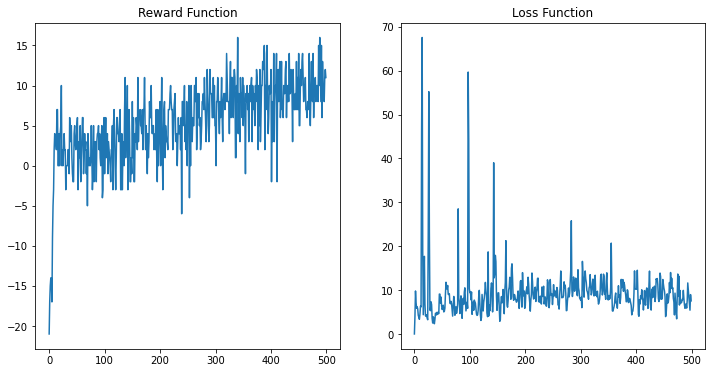

In [ ]:
plot_loss_reward(total_losses, total_rewards)

In [ ]:
from sklearn import metrics
q = chainer.as_array(q)
print('MAE : ' , metrics.mean_absolute_error(target,q))
print('MSE : ' , metrics.mean_squared_error(target,q))
print('RMSE : ' , np.sqrt(metrics.mean_squared_error(target,q)))

MAE :  0.13309538
MSE :  0.06605913
RMSE :  0.2570197


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



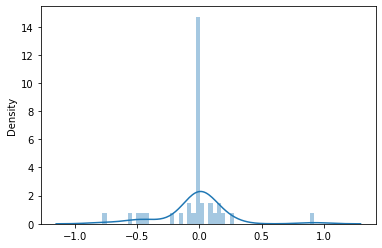

In [ ]:
sns.distplot((target-q))
plt.xlabel('Differences of observed and predicted capacity')

Training Using Environment2

In [ ]:
Q, total_losses, total_rewards, target, q = train_dqn(Environment2(train))

Epoch:5     step:590     reward:64.0     loss:9.073221518099308
Epoch:10     step:1180     reward:98.0     loss:24.099143493920565
Epoch:15     step:1770     reward:112.8     loss:37.919597290456295
Epoch:20     step:2360     reward:114.2     loss:42.2371454924345
Epoch:25     step:2950     reward:112.4     loss:40.149739435315134
Epoch:30     step:3540     reward:110.4     loss:38.28682329505682
Epoch:35     step:4130     reward:112.4     loss:38.177783040702344
Epoch:40     step:4720     reward:112.0     loss:36.83026022017002
Epoch:45     step:5310     reward:111.4     loss:35.11560510843992
Epoch:50     step:5900     reward:111.4     loss:36.11189938187599
Epoch:55     step:6490     reward:112.0     loss:34.506193566322324
Epoch:60     step:7080     reward:113.8     loss:33.118904762715104
Epoch:65     step:7670     reward:110.6     loss:30.63548440039158
Epoch:70     step:8260     reward:111.0     loss:28.819895647466183
Epoch:75     step:8850     reward:113.0     loss:29.02195077

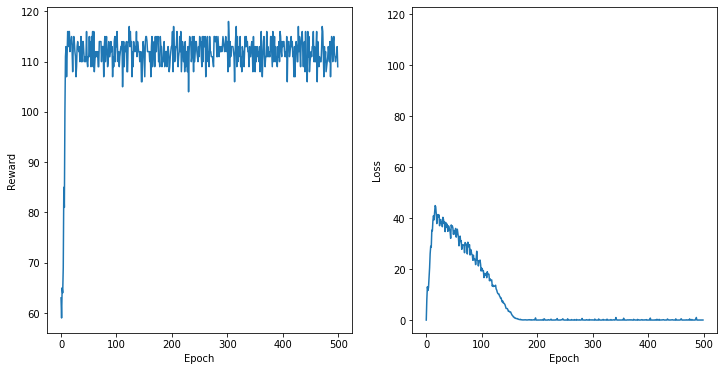

In [ ]:
plot_loss_reward(total_losses, total_rewards)

In [ ]:
from sklearn import metrics
q = chainer.as_array(q)
print('MAE : ' , metrics.mean_absolute_error(target,q))
print('MSE : ' , metrics.mean_squared_error(target,q))
print('RMSE : ' , np.sqrt(metrics.mean_squared_error(target,q)))

MAE :  0.020606328
MSE :  0.000849782
RMSE :  0.02915102


In [ ]:
q

array([[32.35797 , 33.356865],
       [32.35735 , 33.358788],
       [32.35765 , 33.35786 ],
       [32.357826, 33.357323],
       [32.358013, 33.35675 ],
       [32.357876, 33.35718 ],
       [32.358383, 33.355602],
       [32.3575  , 33.358315],
       [32.357616, 33.357964],
       [32.357616, 33.357964],
       [32.357082, 33.359596],
       [32.35673 , 33.36069 ],
       [32.35684 , 33.360367],
       [32.35708 , 33.359623],
       [32.358074, 33.356533],
       [32.35816 , 33.35628 ],
       [32.357872, 33.357178],
       [32.35709 , 33.359585],
       [32.35802 , 33.356716],
       [32.357018, 33.359814]], dtype=float32)

In [ ]:
target

array([[32.35797 , 33.31662 ],
       [32.316536, 33.358788],
       [32.35765 , 33.31664 ],
       [32.357826, 33.316   ],
       [32.358013, 33.316074],
       [32.357876, 33.31684 ],
       [32.358383, 33.31599 ],
       [32.3575  , 33.316685],
       [32.357616, 33.31699 ],
       [32.357616, 33.31699 ],
       [32.357082, 33.316734],
       [32.35673 , 33.317238],
       [32.35684 , 33.317528],
       [32.35708 , 33.317635],
       [32.358074, 33.31664 ],
       [32.35816 , 33.316105],
       [32.357872, 33.31684 ],
       [32.35709 , 33.317772],
       [32.35802 , 33.316032],
       [32.357018, 33.317413]], dtype=float32)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



Text(0.5, 0, 'Differences of observed and predicted capacity')

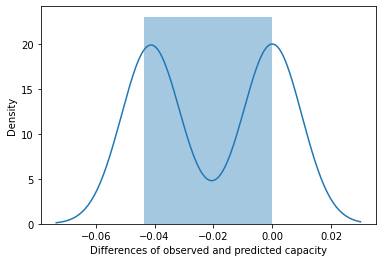

In [ ]:
sns.distplot((target-q))
plt.xlabel('Differences of observed and predicted capacity')

In [ ]:
def plot_train_test_by_q(train_env, test_env, Q, algorithm_name):
    date_split = 100
    # train
    pobs = train_env.reset()
    train_acts = []
    train_rewards = []

    for _ in range(len(train_env.data)-1):
        
        pact = Q(np.array(pobs, dtype=np.float32).reshape(1, -1))
        pact = np.argmax(pact.data)
        train_acts.append(pact)
            
        obs, reward, done = train_env.step(pact)
        train_rewards.append(reward)

        pobs = obs
        
    train_profits = train_env.profits
    
    # test
    pobs = test_env.reset()
    test_acts = []
    test_rewards = []

    for _ in range(len(test_env.data)-1):
    
        pact = Q(np.array(pobs, dtype=np.float32).reshape(1, -1))
        pact = np.argmax(pact.data)
        test_acts.append(pact)
            
        obs, reward, done = test_env.step(pact)
        test_rewards.append(reward)

        pobs = obs
        
    test_profits = test_env.profits
    
    # plot
    train_copy = train_env.data.copy()
    test_copy = test_env.data.copy()
    train_copy['act'] = train_acts + [np.nan]
    train_copy['reward'] = train_rewards + [np.nan]
    test_copy['act'] = test_acts + [np.nan]
    test_copy['reward'] = test_rewards + [np.nan]
    train0 = train_copy[train_copy['act'] == 0]
    train1 = train_copy[train_copy['act'] == 1]
    test0 = test_copy[test_copy['act'] == 0]
    test1 = test_copy[test_copy['act'] == 1]
    act_color0, act_color1 = 'magenta', 'cyan'

    data = [
        Candlestick(x=train0.index,  open=train0['Capacity'], high=train0['Capacity'], low=train0['Capacity'], close=train0['Capacity'], increasing=dict(line=dict(color=act_color0)), decreasing=dict(line=dict(color=act_color0))),
        Candlestick(x=train1.index,  open=train1['Capacity'], high=train1['Capacity'], low=train1['Capacity'], close=train1['Capacity'], increasing=dict(line=dict(color=act_color1)), decreasing=dict(line=dict(color=act_color1))),
        Candlestick(x=test0.index,   open=test0['Capacity'], high=test0['Capacity'], low=test0['Capacity'], close=test0['Capacity'], increasing=dict(line=dict(color=act_color0)), decreasing=dict(line=dict(color=act_color0))),
        Candlestick(x=test1.index,   open=test1['Capacity'], high=test1['Capacity'], low=test1['Capacity'], close=test1['Capacity'], increasing=dict(line=dict(color=act_color1)), decreasing=dict(line=dict(color=act_color1)))
    ]
    title = '{}: train s-reward {}, profits {}, test s-reward {}, profits {}'.format(
        algorithm_name,
        int(sum(train_rewards)),
        int(train_profits),
        int(sum(test_rewards)),
        int(test_profits)
    )
    layout = {
        'title': title,
        'showlegend': True,
         'shapes': [
             {'x0': date_split, 'x1': date_split, 'y0': 0, 'y1': 1, 'xref': 'x', 'yref': 'paper', 'line': {'color': 'rgb(0,0,0)', 'width': 1}}
         ],
        'annotations': [
            {'x': date_split, 'y': 1.0, 'xref': 'x', 'yref': 'paper', 'showarrow': False, 'xanchor': 'left', 'text': ' test data'},
            {'x': date_split, 'y': 1.0, 'xref': 'x', 'yref': 'paper', 'showarrow': False, 'xanchor': 'right', 'text': 'train data '}
        ]
    }
    figure = Figure(data=data, layout=layout)
    iplot(figure)
    return train0, train1, test0, test1

In [ ]:
train0, train1, test0, test1 = plot_train_test_by_q(Environment1(train), Environment1(test), Q, 'DQN')